# GALSEDATLAS AGN Composites and It's effect on the AGN Selection Colourspaces
This code is intended to test the composite models against against the GALSEDATLAS AGN composites. The code is also intended to test how the composites behave in an AGN Selection colourspace, using filters used in the ZFOURGE survey. The code is intended to be used in the context of the GALSEDATLAS AGN composites, but can be used for any composite model and any AGN selection colourspace. It is intended that all templates will be explored, but ultimatelly a selection of these templates should be refined to be used. 

In [20]:
# Read in all required libraries
# Import in all of the required libraries
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project

# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# setup all the directories we are getting our data from 

# Skirtor models
skirtor_folderpath = os.path.join('datasets', 'Templates', 'Skirtor')

# Swire templates
swire_folderpath = os.path.join('datasets', 'Templates', 'SWIRE')

# Brown templates
brown_folderpath = os.path.join('datasets', 'Templates', 'Brown', '2014','Rest')

# Filters - Read in all Spitzer filters, the ZFourge Ks filter, and the MIPS 24 micron filter

# Spitzer filters
pb_f3_6_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I1.dat')
pb_f4_5_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I2.dat')
pb_f5_8_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I3.dat')
pb_f8_0_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I4.dat')

# ZFOURGE Ks filter
pb_zfourge_ks_path = os.path.join('datasets', 'filters', 'LCO_FourStar.Ks.dat')

# MIPS 24 micron filter
pb_mips_24_path = os.path.join('datasets', 'filters', 'Spitzer_MIPS.24mu.dat')

In [22]:
# Create the passbands for the filters
pb_f3_6 = astSED.Passband(pb_f3_6_path, normalise=False)
pb_f4_5 = astSED.Passband(pb_f4_5_path, normalise=False)
pb_f5_8 = astSED.Passband(pb_f5_8_path, normalise=False)
pb_f8_0 = astSED.Passband(pb_f8_0_path, normalise=False)
pb_zfourge_ks = astSED.Passband(pb_zfourge_ks_path, normalise=False)
pb_mips_24 = astSED.Passband(pb_mips_24_path, normalise=False)



Tau: 7, p: 0.5, q: 0, oa: 50, rr: 20, i: 90


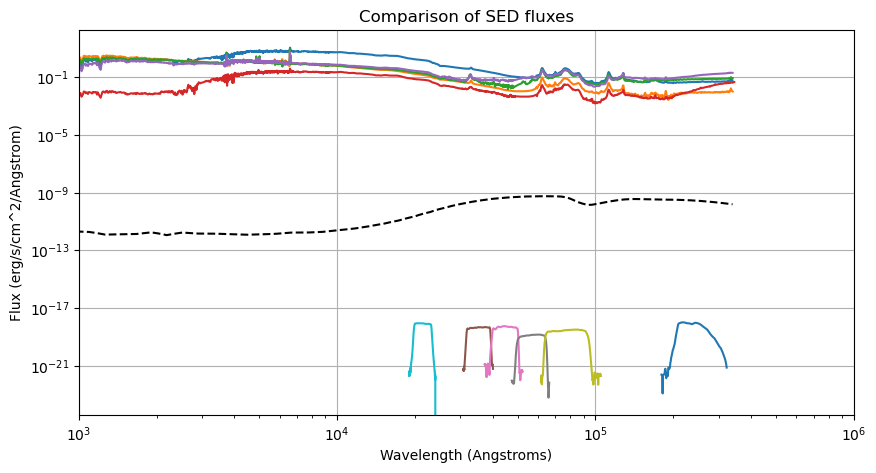

In [23]:
# We aim to explore how the ugr colour space may be influenced by contaminating the galaxy with an agn contribution
tau = SKIRTOR_PARAMS['tau'][2]
p = SKIRTOR_PARAMS['p'][1] # Can make this either 0.5 or 0 (we choose 0.5)
q = SKIRTOR_PARAMS['q'][0] # Make this zero, similar to the Ciesla paper
oa = SKIRTOR_PARAMS['oa'][4] # opening angle of 50 degrees
rr = SKIRTOR_PARAMS['rr'][1] # ratio of 20
i = SKIRTOR_PARAMS['i'][9] # inclination of 0 degrees


# This is again, a new model
agn_model = read_skirtor_model(skirtor_folderpath, tau, p, q, oa, rr, i)

# Print the parameters used in the AGN model
print(f'Tau: {tau}, p: {p}, q: {q}, oa: {oa}, rr: {rr}, i: {i}')

# For completeness we will try to read in all of the galsedatlas templates 
# if this gives bad results we will selectively choose a large section of these templates
# read in all the template names
galsedatlas_templates, objname_list = read_brown_galaxy_templates(brown_folderpath)


# Reduce the number of templates to a smaller number, say 1
#galsedatlas_templates = galsedatlas_templates[:15]

# Make sure AGN are correctly scaled against the galaxy range   
# Have an original AGN model to adjust against 
type_1_agn = agn_model.copy()
type1agn_models = []


# When adjusting, we need to make sure we interpolate the data correctly at each point, 
# so for a specific AGN model this needs to be interpolated correctly against the relevant galaxy template
# essentially each AGN model will be specifically cut for it's template.
for i, template in enumerate(galsedatlas_templates):
    galsedatlas_templates[i], agn_model = adjust_wavelength_range(template, agn_model)   
    type1agn_models.append(agn_model)
    agn_model = type_1_agn.copy()


# Using the same alpha as before, we can create a composite of the AGN and the galaxy
# Use this as a comparison, but in actuality each AGN model will be adjusted to the specific galaxy template
wl_agn = type1agn_models[0]['lambda (Angstroms)']
fl_agn = type1agn_models[0]['Total Flux (erg/s/cm^2/Angstrom)']


plt.figure(figsize=(10, 5))
for i, template in enumerate(galsedatlas_templates):
    
    # Only plotting the first 5 templates
    if i < 5:
        wl = template['lambda (Angstroms)']
        fl = template['Total Flux (erg/s/cm^2/Angstrom)']
        plt.loglog(wl, fl, label=objname_list[i])
    
    
plt.loglog(wl_agn, fl_agn, label='Type 1 AGN', color='black', linestyle='--')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()

# Plotting all the filters to show where the filters observe in
f3_6_arr = np.array(pb_f3_6.asList())
f4_5_arr = np.array(pb_f4_5.asList())
f5_8_arr = np.array(pb_f5_8.asList())
f8_0_arr = np.array(pb_f8_0.asList())
ks_arr = np.array(pb_zfourge_ks.asList())
mips_24_arr = np.array(pb_mips_24.asList())
sc = 1e-18
plt.loglog(f3_6_arr[:, 0], sc*f3_6_arr[:,1])
plt.loglog(f4_5_arr[:, 0], sc*f4_5_arr[:,1])
plt.loglog(f5_8_arr[:, 0], sc*f5_8_arr[:,1])
plt.loglog(f8_0_arr[:, 0], sc*f8_0_arr[:,1])
plt.loglog(ks_arr[:, 0], sc*ks_arr[:,1])
plt.loglog(mips_24_arr[:, 0], sc*mips_24_arr[:,1])
plt.xlim(1e3, 1e6)
plt.show()





In [24]:

# Create a list of alpha values
spacing = 11
alpha = np.linspace(0, 1, spacing)
type1composites = []

# Create new composites
composite_alpha = []


for a in alpha:
    # for this value of alpha create a composite for each template
    composite_templates = []
    for i, template in enumerate(galsedatlas_templates):
        agn_model = type1agn_models[i]
        composite_galaxy = create_gal_agn_composite_sed(agn_model, template, a, 1)
        composite_templates.append(composite_galaxy)
    composite_alpha.append(composite_templates)
    


In [25]:
list_of_alpha_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 

## Instead of creating lists of colour we will instead save the calcFlux in the relevant passband,
## conver this to a colour as per the selections - 

## for lacy we are considering the following colours
## log(f5_8/f3_6) and log(f8_0/f4_5) - we will use the same passbands as before

f_5836_specific_alpha_colours = []
f_8045_specific_alpha_colours = []
redshifts_alpha_list = []

f_5836_colours =[]
f_8045_colours = []
redshifts_list = []


for n in list_of_alpha_indices:
    
    
    # This will be the set of composites for the specific alpha value
    sed_alpha_data = composite_alpha[n] # 127 compsites at a specific alpha value
    for sed_data in sed_alpha_data:
        
        # Create an SED object using astSED
        wl = sed_data['lambda (Angstroms)']
        fl = sed_data['Total Flux (erg/s/cm^2/Angstrom)']
        sed = astSED.SED(wavelength=wl, flux=fl, z=0.0) # Create the specified SED object at redshift of 0
        
        # Now we need to redshift the SED templates to the appropriate redshifts, we are going from 0 to 4 in steps of 0.1
        for z in np.arange(0, 0.1, 0.1):
            # Redshift the SED template
            #sed = sed.redshift(z)
            sed.redshift(z)
            
            # Calculate the flux first
            f_5_8 = astSED.SED.calcFlux(sed, pb_f5_8)
            f_3_6 = astSED.SED.calcFlux(sed, pb_f3_6)
            f_8_0 = astSED.SED.calcFlux(sed, pb_f8_0)
            f_4_5 = astSED.SED.calcFlux(sed, pb_f4_5)
            
            
            # Now calculate the associated colours
            f_5836 = np.log10(f_5_8/f_3_6)
            f_8045 = np.log10(f_8_0/f_4_5)
            
            
            # Append colours to list
            f_5836_colours.append(f_5836)
            f_8045_colours.append(f_8045)
            redshifts_list.append(z)
            
    
    
    
       
    
    f_5836_specific_alpha_colours.append(f_5836_colours)
    f_8045_specific_alpha_colours.append(f_8045_colours)
    redshifts_alpha_list.append(redshifts_list)
    
    
    
    f_5836_colours = []
    f_8045_colours = []
    redshifts_list = []
    
    
            
            
            

        

 
# we need to make sure there are pd.Dataframes for each of the ugr colours at each value of alpha
# at each specific alpha value, we have a list of ugr colours, we need to convert the datafram inside the list into a pd.DataFrame
# for each value
f_5836_specific_alpha_colours = [pd.DataFrame(f_5836) for f_5836 in f_5836_specific_alpha_colours]
f_8045_specific_alpha_colours = [pd.DataFrame(f_8045) for f_8045 in f_8045_specific_alpha_colours]
redshifts_alpha_list = [pd.DataFrame(redshifts) for redshifts in redshifts_alpha_list]





In [26]:
g = 0


for g in range(0, 11):
    print(len(f_5836_specific_alpha_colours[g]))
    print(len(f_8045_specific_alpha_colours[g]))

128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128


In [30]:
# # We will need to plot have a selection
# # Using a variation of my code from capstone
# alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# xmax = 0.8
# ymax = 1.2
# xmin = -0.6
# ymin = -0.8

# for n in range(len(list_of_alpha_indices)):
#     print(n)
#     plt.figure(figsize=(10, 10))
    

    
#     # We are now able to plot the selection diagram for all the GALSEDATLAS templates
#     # We will plot the the diagram for all redshifts an templates in one go
#     x = f_5836_specific_alpha_colours[n]
#     y = f_8045_specific_alpha_colours[n]

#     lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)

    
#     plt.scatter(x[lacy_selection_condition], y[lacy_selection_condition], c='red', s=10, label="Selected")
#     plt.scatter(x[~lacy_selection_condition], y[~lacy_selection_condition],c='grey', s=10, label="Not Selected")
    

#     plt.colorbar(label='Redshift')
    
    
#     fs = 12 # Fontsize
    
#     # set size plotting limits

    
#     wedge_vertices = [
#     (xmax, -0.2),
#     (-0.1, -0.2),
#     (-0.1, 0.8*np.nanmin(x[lacy_selection_condition]) + 0.5 if np.any(lacy_selection_condition) else -0.2),  # Handle empty selection
#     (((ymax-0.5)/0.8), ymax)
# ] 
#     # Create a polygon patch for the AGN wedge
#     wedge_polygon = plt.Polygon(wedge_vertices, closed=False, edgecolor='r', facecolor='none', linestyle='-', linewidth=2, label='Lacy Wedge')
    
#     # Add the AGN wedge polygon patch to the plot
#     plt.gca().add_patch(wedge_polygon)

#     # Add labels and title
#     plt.xlabel('log(f$_{5.8}$/f$_{3.6}$)', fontsize=fs)
#     plt.ylabel('log(f$_{8.0}$/f$_{4.5}$)', fontsize=fs)

#     # Set the limits
#     plt.xlim([xmin, xmax])
#     plt.ylim([ymin, ymax])

#     # Set the ticks
#     plt.xticks([-0.5, 0, 0.5], fontsize=fs)
#     plt.yticks([-0.5, 0, 0.5, 1.0], fontsize=fs)
#     plt.minorticks_on()
    
#     plt.title("Type 2 SED Composites for alpha = " + str(alphas[n]) +"", fontsize=fs)
    
    
#     plt.legend()
    
    
    
#     # Save each plot
#     #plt.savefig(f'outputs/UGRPlots/ugr_alpha_{alphas[n]}.png')

#     # plt.show()

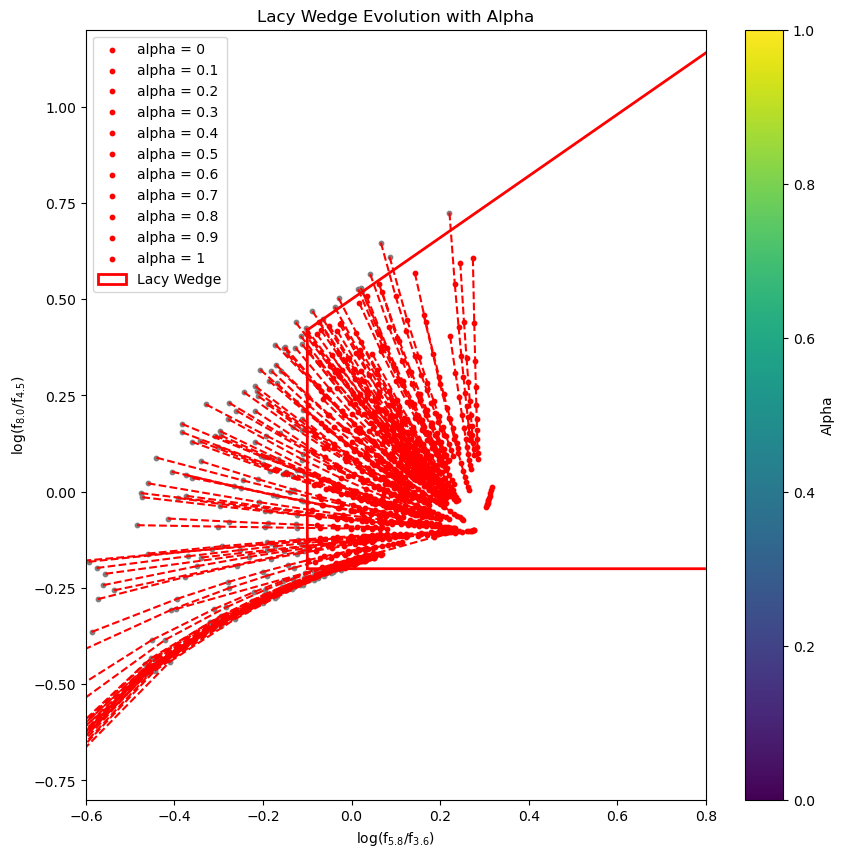

In [44]:
# Create 1 plot showing the evolution of the Lacy wedge with alpha
plt.figure(figsize=(10, 10))
xmax = 0.8
ymax = 1.2
xmin = -0.6
ymin = -0.8
# setup limits
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

# Refine alphas
spacing = 11
alpha_vals = np.linspace(0, 1, spacing)

for n in range(len(list_of_alpha_indices)):
    x = f_5836_specific_alpha_colours[n]
    y = f_8045_specific_alpha_colours[n]
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    # plt.scatter(x[lacy_selection_condition], y[lacy_selection_condition], c='r', s=10, label=f'alpha = {alphas[n]}')
    # Colour code for each alpha
    plt.scatter(x[lacy_selection_condition], y[lacy_selection_condition], c=alpha_vals[n], s=10)
    plt.scatter(x[~lacy_selection_condition], y[~lacy_selection_condition], c='grey', s=10)
    
    
    # Connect each point with a line (as we are looping through alpha values we can connect the points the first point from n to the first point of n+1)
    if n < len(list_of_alpha_indices) - 1:
        x_next = f_5836_specific_alpha_colours[n+1]
        y_next = f_8045_specific_alpha_colours[n+1]
        plt.plot([x[0], x_next[0]], [y[0], y_next[0]], c='r', linestyle='--')
        
        
    
# Redefine x and y for the first alpha value to plot the wedge
x = f_5836_specific_alpha_colours[0]
y = f_8045_specific_alpha_colours[0]
#Plot the selection wedge based on the first alpha value

# Reimplement the selection criteria
lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)

wedge_vertices = [
    (xmax, -0.2),
    (-0.1, -0.2),
    (-0.1, 0.8*np.nanmin(x[lacy_selection_condition]) + 0.5 if np.any(lacy_selection_condition) else -0.2),  # Handle empty selection
    (((ymax-0.5)/0.8), ymax)
] 
wedge_polygon = plt.Polygon(wedge_vertices, closed=False, edgecolor='r', facecolor='none', linestyle='-', linewidth=2, label='Lacy Wedge')
plt.gca().add_patch(wedge_polygon)

    
plt.colorbar(label='Alpha')
plt.xlabel('log(f$_{5.8}$/f$_{3.6}$)')
plt.ylabel('log(f$_{8.0}$/f$_{4.5}$)')
plt.title('Lacy Wedge Evolution with Alpha')
plt.legend()
plt.show()
